In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast
# noinspection PyUnresolvedReferences
from mamba_ssm import Mamba
import matplotlib.pyplot as plt

In [3]:
df_train_raw = pd.read_csv('train.csv', encoding='cp1252')
df_val_raw = pd.read_csv('test.csv', encoding='cp1252')

df = pd.concat([df_train_raw, df_val_raw], ignore_index=True)
df = df.filter(["text", "sentiment"]).dropna()

valid_sentiments = {"negative", "neutral", "positive"}
label_map = {"negative": 0, "neutral": 1, "positive": 2}

df = df[df["sentiment"].isin(valid_sentiments)].copy()
df["label"] = df["sentiment"].map(label_map).astype(int)
df["text"] = df["text"].astype(str)

df['label'].value_counts(normalize=True)

label
1    0.404559
2    0.312278
0    0.283162
Name: proportion, dtype: float64

In [4]:
df_train, df_val = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    shuffle=True,
    random_state=42
)

In [5]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

SEQ_LENGTH = 64

In [6]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.texts = dataframe["text"].tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [7]:
class MambaBlock(nn.Module):
    def __init__(self, dim, dropout=0.5):
        super().__init__()
        self.mamba = Mamba(d_model=dim)
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return x + self.dropout(self.mamba(self.norm(x)))


class MambaModel(nn.Module):
    def __init__(self, vocab_size, num_classes=3, hidden_dim=128, max_len=128, num_layers=1, dropout=0.5,
                 padding_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=padding_idx)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, hidden_dim))
        self.mamba_layers = nn.Sequential(*[MambaBlock(hidden_dim, dropout=dropout) for _ in range(num_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        max_pos = self.positional_encoding.size(1)
        seq_len = min(input_ids.size(1), max_pos)

        pos_encoding = self.positional_encoding[:, :seq_len, :]

        x = self.embedding(input_ids[:, :seq_len]) + pos_encoding
        attention_mask = attention_mask[:, :seq_len]

        x = x * attention_mask.unsqueeze(-1)
        x = self.mamba_layers(x)

        masked_sum = (x * attention_mask.unsqueeze(-1)).sum(dim=1)
        lengths = attention_mask.sum(dim=1).clamp(min=1).unsqueeze(1)
        pooled = masked_sum / lengths

        return self.classifier(pooled)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_loader = DataLoader(SentimentDataset(df_train, SEQ_LENGTH), batch_size=32, shuffle=True)
val_loader = DataLoader(SentimentDataset(df_val, SEQ_LENGTH), batch_size=32, shuffle=False)

model = MambaModel(
    vocab_size=tokenizer.vocab_size,
    hidden_dim=128,
    max_len=SEQ_LENGTH,
    padding_idx=tokenizer.pad_token_id
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            val_loss += loss.item() * input_ids.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    print(f"Epoch {epoch + 1}/{EPOCHS} - loss: {total_loss / total:.3f}")

Epoch 1/10 - loss: 0.996
Epoch 2/10 - loss: 0.784
Epoch 3/10 - loss: 0.694
Epoch 4/10 - loss: 0.617
Epoch 5/10 - loss: 0.543
Epoch 6/10 - loss: 0.476
Epoch 7/10 - loss: 0.403
Epoch 8/10 - loss: 0.338
Epoch 9/10 - loss: 0.272
Epoch 10/10 - loss: 0.219


In [9]:
for key in model.mamba_layers[0].state_dict().keys():
    print(key)

mamba.A_log
mamba.D
mamba.in_proj.weight
mamba.conv1d.weight
mamba.conv1d.bias
mamba.x_proj.weight
mamba.dt_proj.weight
mamba.dt_proj.bias
mamba.out_proj.weight
norm.weight
norm.bias


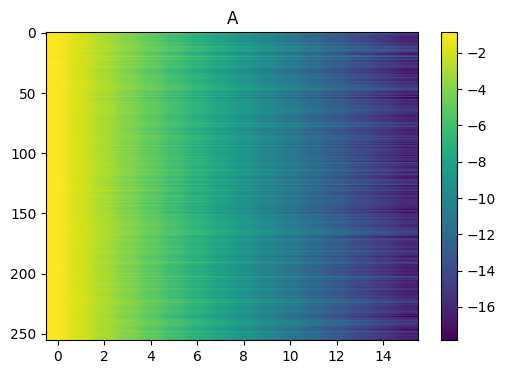

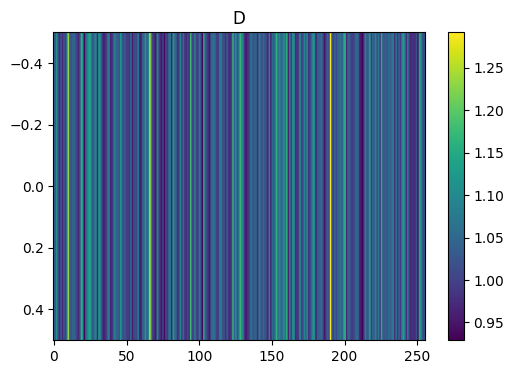

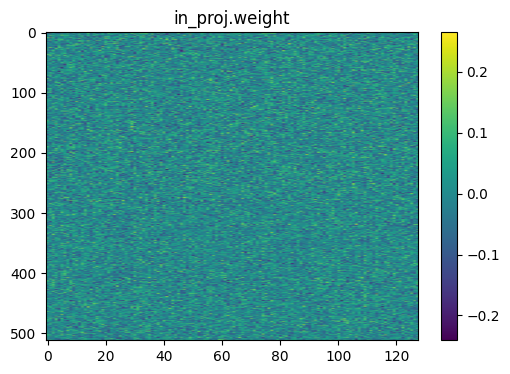

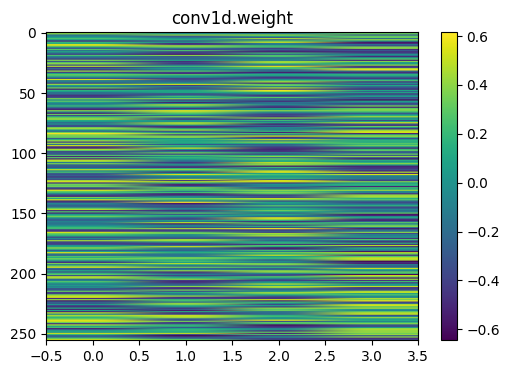

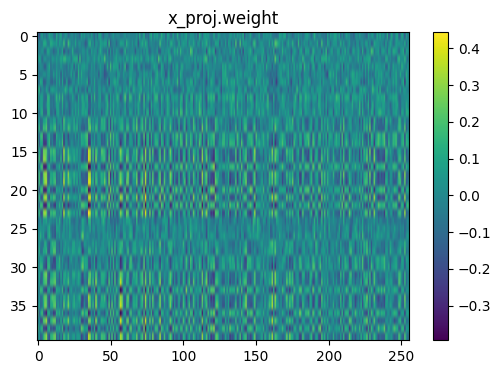

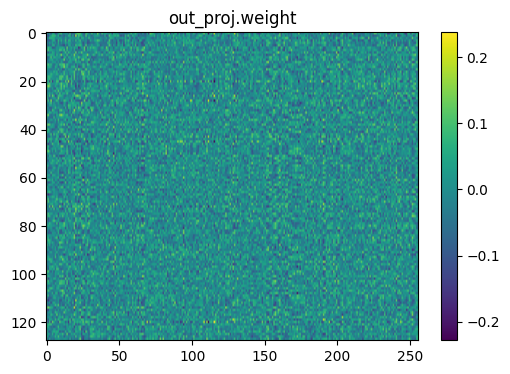

In [16]:
state_dict = model.mamba_layers[0].state_dict()


def plot_matrix(tensor, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(tensor.cpu().numpy(), cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.show()

def plot_matrix_exp(tensor, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(-np.exp(tensor.cpu().numpy()), cmap="viridis", aspect="auto")
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_matrix_exp(state_dict["mamba.A_log"], "A")
plot_matrix(state_dict["mamba.D"].unsqueeze(0), "D")
plot_matrix(state_dict["mamba.in_proj.weight"], "in_proj.weight")
plot_matrix(state_dict["mamba.conv1d.weight"].squeeze(), "conv1d.weight")
plot_matrix(state_dict["mamba.x_proj.weight"], "x_proj.weight")
plot_matrix(state_dict["mamba.out_proj.weight"], "out_proj.weight")

In [11]:
print(model.mamba_layers[0].mamba.A_log.shape)
print(model.mamba_layers[0].mamba.D.shape)

torch.Size([256, 16])
torch.Size([256])


# Summary

1) Regarded Mamba implementation, I've used [mamba_ssm](https://github.com/state-spaces/mamba) (honestly, it has finicky dependencies and broken pip wheels, so it took a while to make it work. Specifically: wrap in custom CUDA-compatible docker, comprehensive research about which versions of Python (spoiler, 3.10) and [casual-conv1d](https://github.com/Dao-AILab/causal-conv1d) library will be compatible.

2) Similar to transformers and our eyes, model tends to pay more "attention" to first phrases. This is hidden in A matrix

3) As for the hidden state, the vertical stripes suggest that model tends to pay different attention to specific coordinates depending on token's meaning. This is D matrix

4) te convolution layers seems to have a similar pattern. I assume that it implicitly perform similar coordinate-based filtering depending on hidden vector
